**Feyza Orak -- Path Planning for Autonomous Agent with Reinforcement Learning** 

In [460]:
import os
import sys
import time
import datetime
import json
import random
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
from collections import defaultdict
from IPython.display import clear_output
from matplotlib.colors import ListedColormap

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


In [461]:
visited_mark = 0.8  # Cells visited by the rat will be painted by gray 0.8
rat_mark = 0.5      # The current rat cell will be painteg by gray 0.5
LEFT = 0
UP = 1
RIGHT = 2
DOWN = 3

# Actions dictionary
actions_dict = {
    LEFT: 'left',
    UP: 'up',
    RIGHT: 'right',
    DOWN: 'down',
}

num_actions = len(actions_dict)


In [462]:
class MazeGraph:
    def __init__(self, maze):
        self._maze = np.array(maze)
        self.rows, self.cols = self._maze.shape
        self.graph = defaultdict(list)
        # Using the existing action constants
        self.actions = [LEFT, UP, RIGHT, DOWN]  
        self.build_graph()

    def is_valid_move(self, x, y):
        """Check if move is valid (within bounds and cell is free)"""
        return (0 <= x < self.rows and 
                0 <= y < self.cols and 
                self._maze[x][y] == 1.0) #0 duvar

    def build_graph(self):
        """Builds connectivity graph of the maze"""
        for i in range(self.rows):
            for j in range(self.cols):
                if self._maze[i][j] == 1.0:  # Only build for free cells
                    for action in self.actions:
                        ni, nj = i, j
                        if action == LEFT:
                            nj -= 1
                        elif action == UP:
                            ni -= 1
                        elif action == RIGHT:
                            nj += 1
                        elif action == DOWN:
                            ni += 1
                            
                        if self.is_valid_move(ni, nj):
                            self.graph[(i, j)].append(((ni, nj), action))

    def get_valid_actions(self, current_state):
        """Get valid actions for current state"""
        valid_moves = self.graph[current_state]
        return [action for _, action in valid_moves]
    
    def display_graph(self):
        for node, edges in self.graph.items():
            print(f"{node} -> {edges}")

In [463]:
# maze is a 2d Numpy array of floats between 0.0 to 1.0
# 1.0 corresponds to a free cell, and 0.0 an occupied cell
# rat = (row, col) initial rat position (defaults to (0,0))

class Qmaze(MazeGraph):
    def __init__(self, maze, rat):
        super().__init__(maze)
        nrows, ncols = self._maze.shape
        self.target = (nrows-1, ncols-1)   # target cell where the "cheese" is
        self.free_cells = [(r,c) for r in range(nrows) for c in range(ncols) if self._maze[r,c] == 1.0]
        self.free_cells.remove(self.target)
        if self._maze[self.target] == 0.0:
            raise Exception("Invalid maze: target cell cannot be blocked!")
        if not rat in self.free_cells:
            raise Exception("Invalid Rat Location: must sit on a free cell")
        self.reset(rat)

    def reset(self, rat):
        self.rat = rat
        self.maze = np.copy(self._maze)
        nrows, ncols = self.maze.shape
        row, col = rat
        #self.maze[row, col] = rat_mark
        self.state = (row, col, 'start')
        self.min_reward = -0.5 * self.maze.size
        self.total_reward = 0
        self.visited = set()

    def update_state(self, action):
        nrows, ncols = self.maze.shape
        nrow, ncol, nmode = rat_row, rat_col, mode = self.state

        if self.maze[rat_row, rat_col] > 0.0:
            self.visited.add((rat_row, rat_col))  # mark visited cell

        valid_actions = self.valid_actions()
                

        if action in valid_actions:
            nmode = 'valid'
            if action == LEFT:
                ncol -= 1
            elif action == UP:
                nrow -= 1
            if action == RIGHT:
                ncol += 1
            elif action == DOWN:
                nrow += 1

        # new state
        self.state = (nrow, ncol, nmode)

    def get_reward(self):
        rat_row, rat_col, mode = self.state
        nrows, ncols = self.maze.shape
        if rat_row == nrows-1 and rat_col == ncols-1:
            return 1.0
        if (rat_row, rat_col) in self.visited:
            return -0.55
        if mode == 'valid':
            return -0.04

    def act(self, action):
        self.update_state(action)
        reward = self.get_reward()
        self.total_reward += reward
        status = self.game_status()
        envstate = self.observe()
        return envstate, reward, status

    def observe(self):
        canvas = self.draw_env()
        envstate = canvas.reshape((1, -1))
        return envstate

    def draw_env(self):
        canvas = np.copy(self.maze)
        nrows, ncols = self.maze.shape
        # clear all visual marks
        for r in range(nrows):
            for c in range(ncols):
                if canvas[r,c] > 0.0:
                    canvas[r,c] = 1.0
        # draw the rat
        row, col, valid = self.state
        canvas[row, col] = rat_mark
        return canvas

    def game_status(self):
        if self.total_reward < self.min_reward:
            return 'lose'
        rat_row, rat_col, mode = self.state
        nrows, ncols = self.maze.shape
        if rat_row == nrows-1 and rat_col == ncols-1:
            return 'win'

        return 'not_over'

    def valid_actions(self, cell=None):
        #burayla oynaman gerekiyor
        if cell is None:
            row, col, _ = self.state
            current_pos = (row, col)
        else:
            current_pos = cell
            
        return self.get_valid_actions(current_pos)

In [464]:
def show(qmaze):
    plt.grid('on')
    nrows, ncols = qmaze.maze.shape
    ax = plt.gca()
    ax.set_xticks(np.arange(0.5, nrows, 1))
    ax.set_yticks(np.arange(0.5, ncols, 1))
    ax.set_xticklabels([])
    ax.set_yticklabels([])
    canvas = np.copy(qmaze.maze)
    for row,col in qmaze.visited:
        canvas[row,col] = 0.6
    rat_row, rat_col, _ = qmaze.state
    canvas[rat_row, rat_col] = 0.3   # rat cell
    canvas[nrows-1, ncols-1] = 0.9 # cheese cell
    img = plt.imshow(canvas, interpolation='none', cmap='gray')
    return img

In [465]:
def create_maze(size):
    maze = np.zeros((size, size), dtype=float)
    
    # start and end points
    start = (0, 0)
    end = (size-1, size-1)
    
    # Agent path
    agent_path = [start]
    
    # current position
    current_pos = start
    
    # actions (right, down, left, up)
    directions = [(0, 1), (1, 0), (0, -1), (-1, 0)]
    
    # continue until reaching to end point
    while current_pos != end:
        valid_moves = []
        
        # check all directions
        for d in directions:
            new_pos = (current_pos[0] + d[0], current_pos[1] + d[1])
            
            # is it in maze bounds and previous step?
            if 0 <= new_pos[0] < size and 0 <= new_pos[1] < size and (len(agent_path) < 2 or new_pos != agent_path[-2]):
                valid_moves.append(new_pos)
        
        if not valid_moves:
            break
        
        current_pos = random.choice(valid_moves)

        # loop detection
        if current_pos in agent_path:
            loop_start_index = agent_path.index(current_pos)
            loop_steps = agent_path[loop_start_index:]  # Döngüdeki adımlar
            
            # remove loop steps
            for step in loop_steps:
                if step not in agent_path[:loop_start_index]:
                    agent_path.remove(step)

        agent_path.append(current_pos)
    
    # mark path
    for pos in agent_path:
        maze[pos] = 1.0  # Yol
    
    # fill paths without in agent path (with path or wall)
    for i in range(size):
        for j in range(size):
            if (i, j) not in agent_path:
                maze[i, j] = random.choice([0, 1])  # 1: Yol, 0: Duvar
    
    # start and end point fix
    maze[start] = 1.0  
    maze[end] = 1.0   
    
    return maze, agent_path

def visualize_maze(maze):

    # Create a copy of the maze for visualization
    viz_maze = maze.copy()
    # Convert 0s to 2s for walls in visualization
    viz_maze[maze == 0] = 2
    
    # colormap color settings
    cmap = ListedColormap(['black', 'white', 'green', 'yellow'])  # 0: wall, 1: path, 2: start, 3: end
    maze_colors = np.zeros_like(maze)
    maze_colors[maze == 2] = 0  # wall
    maze_colors[maze == 1] = 1  # path

    start = (0, 0)
    end = (len(maze)-1, len(maze)-1)
    maze_colors[start] = 2  # start
    maze_colors[end] = 3    # end
    
    plt.imshow(maze_colors, cmap=cmap, interpolation='none')
    plt.title("Random Maze")
    plt.colorbar(ticks=[0, 1, 2, 3], label="0:Wall       1:Path        2:Start        3:End")
    plt.savefig('images/maze.png')
    plt.show()

Maze:
[[1. 1. 0. 1. 1. 1. 0. 0. 0. 1. 0. 0. 0. 1. 1.]
 [1. 1. 1. 0. 1. 1. 0. 1. 1. 1. 1. 1. 0. 1. 0.]
 [1. 1. 1. 0. 1. 0. 0. 1. 1. 0. 0. 0. 1. 0. 0.]
 [0. 0. 1. 1. 1. 0. 1. 1. 0. 1. 1. 1. 1. 1. 0.]
 [0. 1. 1. 1. 0. 1. 1. 1. 0. 1. 1. 0. 1. 0. 0.]
 [0. 1. 0. 1. 1. 0. 1. 0. 1. 1. 0. 0. 1. 0. 0.]
 [1. 0. 0. 0. 1. 1. 1. 1. 0. 0. 1. 1. 1. 0. 1.]
 [1. 1. 0. 1. 1. 1. 1. 1. 1. 1. 0. 1. 0. 1. 0.]
 [1. 0. 0. 0. 1. 0. 0. 1. 1. 1. 0. 1. 1. 1. 1.]
 [1. 1. 1. 1. 0. 1. 1. 0. 0. 1. 1. 1. 0. 1. 1.]
 [0. 0. 0. 0. 1. 1. 1. 1. 1. 1. 0. 1. 1. 1. 1.]
 [0. 1. 1. 0. 0. 1. 0. 0. 0. 1. 1. 1. 1. 0. 1.]
 [0. 0. 0. 1. 1. 1. 0. 0. 1. 1. 1. 1. 0. 0. 1.]
 [1. 1. 0. 0. 1. 0. 0. 1. 0. 0. 0. 1. 1. 0. 1.]
 [0. 1. 0. 0. 1. 1. 0. 0. 1. 1. 0. 0. 1. 1. 1.]]
(15, 15)


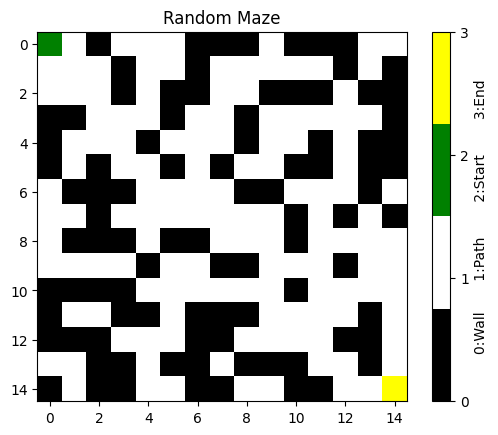

In [466]:
# create maze and visualize
maze_size = 15
maze, _ = create_maze(maze_size)
print("Maze:")
print(maze)
print(np.shape(maze))
visualize_maze(maze)

reward= -0.04


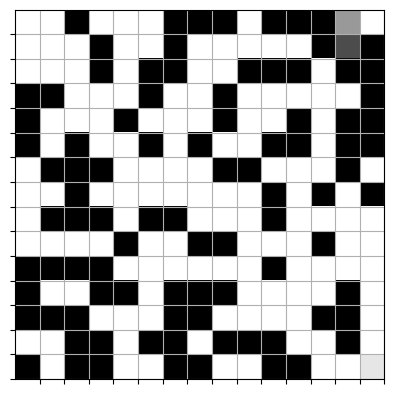

In [467]:
maze_graph = MazeGraph(maze)

#for starting at random state
nrows , ncols =np.shape(maze)
maze=np.array(maze)
maze_free_cells=[(r,c) for r in range(nrows) for c in range(ncols) if maze[r,c] == 1.0]
target=(nrows-1, ncols-1)
maze_free_cells.remove(target)

qmaze = Qmaze(maze,random.choice(maze_free_cells))
canvas, reward, game_over = qmaze.act(DOWN)
print("reward=", reward)
show(qmaze)

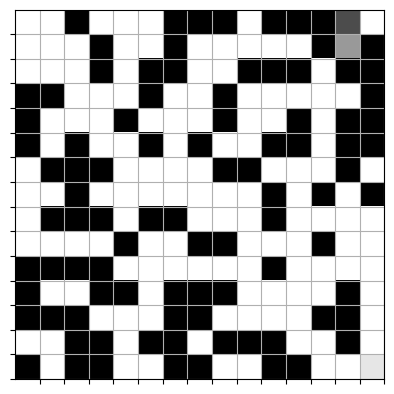

In [468]:
qmaze.act(DOWN)  # move down
qmaze.act(RIGHT)  # move right
qmaze.act(RIGHT)  # move right
qmaze.act(RIGHT)  # move right
qmaze.act(UP)  # move up
show(qmaze)

In [469]:
def play_game(model, qmaze, rat_cell):
    qmaze.reset(rat_cell)
    envstate = qmaze.observe()
    while True:
        prev_envstate = envstate
        # get next action
        q = model(torch.tensor(prev_envstate, dtype=torch.float32).unsqueeze(0).to(device))
        q = q.detach().cpu().numpy()[0]  # if using GPU and want to convert numpy
        action = np.argmax(q)

        # apply action, get rewards and new state
        envstate, reward, game_status = qmaze.act(action)
        if game_status == 'win':
            return True
        elif game_status == 'lose':
            return False

In [470]:
def check_path_to_target(qmaze, start_cell):
   """Check if there exists a path from start_cell to target using BFS"""
   target = qmaze.target
   visited = set()
   queue = [(start_cell)]
   
   while queue:
       current = queue.pop(0)
       if current == target:
           return True
           
       if current not in visited:
           visited.add(current)
           # Get valid neighboring cells
           valid_actions = qmaze.valid_actions(current)
           for action in valid_actions:
               next_row, next_col = current
               if action == LEFT:
                   next_col -= 1
               elif action == UP:
                   next_row -= 1
               elif action == RIGHT:
                   next_col += 1
               elif action == DOWN:
                   next_row += 1
                   
               next_cell = (next_row, next_col)
               if next_cell not in visited:
                   queue.append(next_cell)
                   
   return False

def completion_check(model, qmaze):
   for cell in qmaze.free_cells:
       # First check if there's a valid path from this cell to target
       if not check_path_to_target(qmaze, cell):
           continue
           
       # Only check cells that have a valid path to target
       if not play_game(model, qmaze, cell):
           return False
   return True

In [471]:
class DQNModel(nn.Module):
    def __init__(self, input_dim, output_dim):
        super(DQNModel, self).__init__()
        self.net = nn.Sequential(
            nn.Linear(input_dim, input_dim),
            nn.PReLU(),
            nn.Linear(input_dim, input_dim),
            nn.PReLU(),
            nn.Linear(input_dim, output_dim)
        )
    
    def forward(self, x):
        return self.net(x)

In [472]:
class Experience(object):
    def __init__(self, model, max_memory=100, discount=0.95):
        self.model = model
        self.max_memory = max_memory
        self.discount = discount
        self.memory = list()
        #self.num_actions = model.output_shape[-1]

    def remember(self, episode):
        # episode = [envstate, action, reward, envstate_next, game_over]
        # memory[i] = episode
        # envstate == flattened 1d maze cells info, including rat cell (see method: observe)
        self.memory.append(episode)
        if len(self.memory) > self.max_memory:
            del self.memory[0]

    def predict(self, state):
        state = torch.tensor(state, dtype=torch.float32).unsqueeze(0).to(device)
        with torch.no_grad():
            q_values = self.model(state)
        q_values =q_values.squeeze(0).cpu().numpy()
        return q_values

    def get_data(self, data_size=32):
        data_size = min(data_size, len(self.memory))
        inputs = []
        targets = []
        mem_size = len(self.memory)
        for i, j in enumerate(np.random.choice(range(mem_size), data_size, replace=False)):
            state, action, reward, next_state, game_over = self.memory[j]
            state=state.squeeze()
            state_tensor = torch.tensor(state, dtype=torch.float32)
            #print(np.shape(state_tensor))
            next_state_tensor = torch.tensor(next_state, dtype=torch.float32)
            
            # Predict Q values
            target = self.predict(state).squeeze()
            
            if game_over:
                target[action] = reward
            else:
                q_next = self.predict(next_state)
                #print(np.max(q_next))
                target[action] = reward + self.discount * np.max(q_next)

            inputs.append(state_tensor)
            #print(torch.tensor(target, dtype=torch.float32))
            #print(state_tensor,"state")
            targets.append(torch.tensor(target, dtype=torch.float32))
        
        return torch.stack(inputs), torch.stack(targets)

In [473]:
def qtrain(model, maze, **opt):
    global epsilon
    n_epoch = opt.get('n_epoch', 300000)
    max_memory = opt.get('max_memory', 1000)
    data_size = opt.get('data_size', 50)
    weights_file = opt.get('weights_file', "")
    name = opt.get('name', 'model')
    start_time = datetime.datetime.now()

    # Add epsilon decay parameters
    epsilon_start = 0.9
    epsilon_end = 0.1
    epsilon_decay = 0.99995  # Adjust this value to control decay speed
    epsilon = epsilon_start

    # If you want to continue training from a previous model,
    # just supply the h5 file name to weights_file option
    if weights_file:
        print("loading weights from file: %s" % (weights_file,))
        model.load_state_dict(torch.load(weights_file))

    # Construct environment/game from numpy array: maze (see above)
    qmaze = Qmaze(maze,random.choice(maze_free_cells))

    # Initialize experience replay object
    experience = Experience(model, max_memory=max_memory)

    win_history = []   # history of win/lose game
    n_free_cells = len(qmaze.free_cells)
    hsize = qmaze.maze.size//2   # history window size
    win_rate = 0.0
    imctr = 1
    optimizer = optim.Adam(model.parameters(), lr=0.001)
    criterion = nn.MSELoss()
    # Initialize loss history list before training
    loss_history = []
    epsilon_history = []

    for epoch in range(n_epoch):

        # After each epoch, decay epsilon
        epsilon = max(epsilon_end, epsilon * epsilon_decay)
        #print(epsilon)

        loss = 0.0
        rat_cell = random.choice(qmaze.free_cells)
        qmaze.reset(rat_cell)
        #print("Agent starts at:",rat_cell) #show where rat_cell starts
        game_over = False
        episode_losses = []  # Track losses for this episode

        # get initial envstate (1d flattened canvas)
        envstate = qmaze.observe()

        n_episodes = 0
        step = 0
        
        while not game_over and not step == (maze_size*2):
            step = step + 1
            #print(step)
            valid_actions = qmaze.valid_actions()
            if not valid_actions: break
            prev_envstate = envstate
            # Get next action
            if np.random.rand() < epsilon:
                action = random.choice(valid_actions)
            else:
                action = np.argmax(experience.predict(prev_envstate))

            # Apply action, get reward and new envstate
            envstate, reward, game_status = qmaze.act(action)
            if game_status == 'win':
                win_history.append(1)
                game_over = True
            elif game_status == 'lose':
                win_history.append(0)
                game_over = True
            else:
                game_over = False

            # Store episode (experience)
            episode = [prev_envstate, action, reward, envstate, game_over]
            experience.remember(episode)
            n_episodes += 1

            inputs, targets = experience.get_data(data_size=data_size)
            inputs, targets = inputs.to(device), targets.to(device)
            
            model.train()
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            loss.backward()
            optimizer.step()

            episode_losses.append(loss.item())
        
        # After episode ends, store average loss for this episode
        avg_episode_loss = sum(episode_losses) / len(episode_losses) if episode_losses else 0
        loss_history.append(avg_episode_loss)
        epsilon_history.append(epsilon)
            
        if len(win_history) > hsize:
            win_rate = sum(win_history[-hsize:]) / hsize
    
        dt = datetime.datetime.now() - start_time
        t = format_time(dt.total_seconds())
        template = "Epoch: {:03d}/{:d} | Loss: {:.4f} | Episodes: {:d} | Win count: {:d} | Win rate: {:.3f} | time: {}"
        print(template.format(epoch, n_epoch-1, loss, n_episodes, sum(win_history), win_rate, t))
        # we simply check if training has exhausted all free cells and if in all
        # cases the agent won
        #if win_rate > 0.9 : epsilon = 0.05
        if sum(win_history[-hsize:]) == hsize and completion_check(model, qmaze):
            print("Reached 100%% win rate at epoch: %d" % (epoch,))
            break
    
    torch.save(model.state_dict(), f"{name}.pt")
    print(f"Model saved as {name}.pt")

    end_time = datetime.datetime.now()
    dt = datetime.datetime.now() - start_time
    seconds = dt.total_seconds()
    t = format_time(seconds)
    print("n_epoch: %d, max_mem: %d, data: %d, time: %s" % (epoch, max_memory, data_size, t))
    return seconds,  loss_history, epsilon_history

# This is a small utility for printing readable time strings:
def format_time(seconds):
    if seconds < 400:
        s = float(seconds)
        return "%.1f seconds" % (s,)
    elif seconds < 4000:
        m = seconds / 60.0
        return "%.2f minutes" % (m,)
    else:
        h = seconds / 3600.0
        return "%.2f hours" % (h,)

In [474]:
def build_model(maze):
    input_dim = maze.size
    output_dim = 4  # Actions: up, down, left, right
    model = DQNModel(input_dim, output_dim).to(device)
    return model

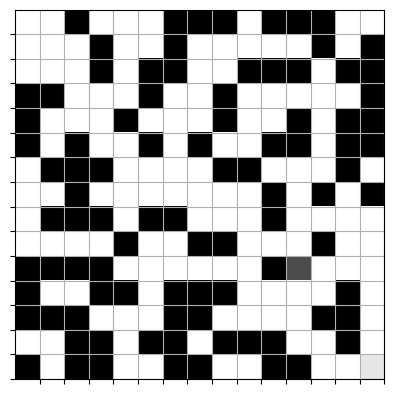

In [475]:
qmaze = Qmaze(maze,random.choice(maze_free_cells))
show(qmaze)

In [476]:
model = build_model(maze)
seconds, loss_history, epsilon_history = qtrain(model, maze, epochs=1000, max_memory=8*maze.size, data_size=32)
#qtrain(model, maze, epochs=1000, max_memory=8*maze.size, data_size=32)

Epoch: 000/299999 | Loss: 0.0161 | Episodes: 30 | Win count: 0 | Win rate: 0.000 | time: 0.5 seconds
Epoch: 001/299999 | Loss: 0.0136 | Episodes: 30 | Win count: 0 | Win rate: 0.000 | time: 1.4 seconds
Epoch: 002/299999 | Loss: 0.0148 | Episodes: 30 | Win count: 0 | Win rate: 0.000 | time: 2.3 seconds
Epoch: 003/299999 | Loss: 0.0184 | Episodes: 11 | Win count: 1 | Win rate: 0.000 | time: 2.6 seconds
Epoch: 004/299999 | Loss: 0.1313 | Episodes: 19 | Win count: 2 | Win rate: 0.000 | time: 3.2 seconds
Epoch: 005/299999 | Loss: 0.0224 | Episodes: 30 | Win count: 2 | Win rate: 0.000 | time: 4.1 seconds
Epoch: 006/299999 | Loss: 0.0225 | Episodes: 30 | Win count: 2 | Win rate: 0.000 | time: 5.0 seconds
Epoch: 007/299999 | Loss: 0.0168 | Episodes: 30 | Win count: 2 | Win rate: 0.000 | time: 5.9 seconds
Epoch: 008/299999 | Loss: 0.0318 | Episodes: 30 | Win count: 2 | Win rate: 0.000 | time: 6.7 seconds
Epoch: 009/299999 | Loss: 0.0158 | Episodes: 16 | Win count: 3 | Win rate: 0.000 | time: 7.

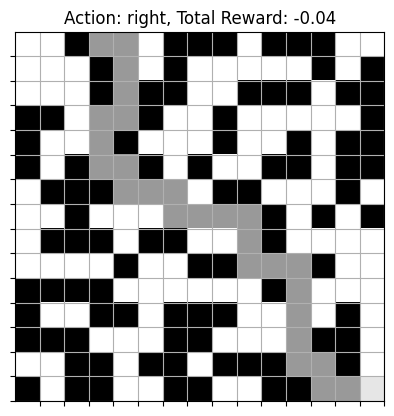

In [477]:
def evaluate_model_display(model, maze, start_cell=(0,0), delay=0.1):
    # Set model to evaluation mode
    model.eval()
    # Initialize the maze
    qmaze = Qmaze(maze,random.choice(maze_free_cells))
    qmaze.reset(random.choice(maze_free_cells))
    game_over = False
    total_reward = 0
    
    while not game_over:
        # Get current state
        state = qmaze.observe()
        
        # Get action from model
        with torch.no_grad():
            state_tensor = torch.tensor(state, dtype=torch.float32).unsqueeze(0).to(device)
            q_values = model(state_tensor)
            action = torch.argmax(q_values).item()
        
        # Take action
        _, reward, game_status = qmaze.act(action)
        total_reward += reward
        
        # Display current state
        clear_output(wait=True)
        show(qmaze)
        plt.title(f'Action: {actions_dict[action]}, Total Reward: {total_reward:.2f}')
        plt.show()
        time.sleep(delay)
        
        # Check if game is over
        if game_status in ['win', 'lose']:
            game_over = True

evaluate_model_display(model, maze, delay=0.1)

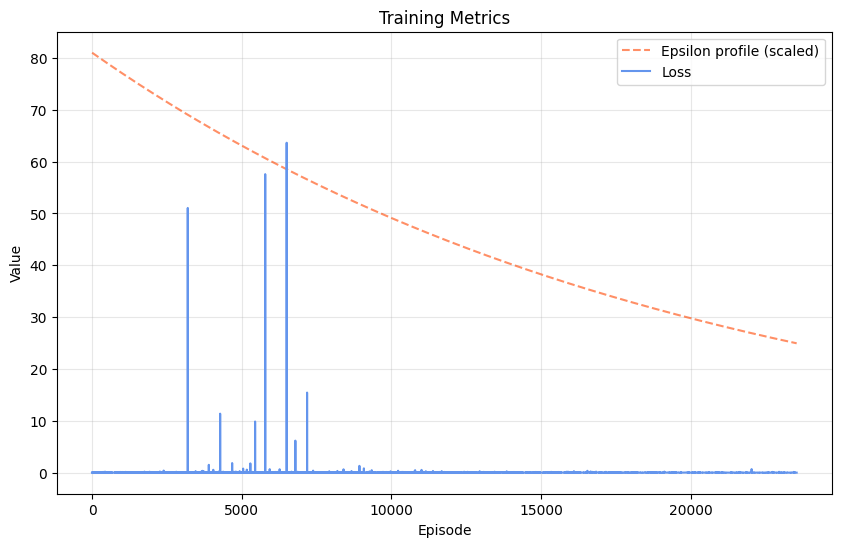

In [478]:
# With scaling
def plot_training_metrics(loss_history, epsilon_history, epsilon_scale=90, save_path=None):
    plt.figure(figsize=(10, 6))
    
    # Plot scaled epsilon profile
    plt.plot(np.array(epsilon_history) * epsilon_scale, 
            alpha=0.6, 
            ls='--', 
            label='Epsilon profile (scaled)', 
            color='orangered')
    
    # Plot loss
    plt.plot(loss_history, 
            label='Loss', 
            color='cornflowerblue')
    
    plt.xlabel('Episode')
    plt.ylabel('Value')
    plt.title('Training Metrics')
    plt.legend()
    plt.grid(True, alpha=0.3)
    
    plt.savefig('images/epsilon-loss-graph.png', dpi=300, bbox_inches='tight')
    
    plt.show()

# After training, plot the metrics
plot_training_metrics(loss_history, epsilon_history, save_path='training_metrics.pdf')

(15, 15)
[[1. 1. 0. 1. 1. 1. 0. 0. 0. 1. 0. 0. 0. 1. 1.]
 [1. 1. 1. 0. 1. 1. 0. 1. 1. 1. 1. 1. 0. 1. 0.]
 [1. 1. 1. 0. 1. 0. 0. 1. 1. 0. 0. 0. 1. 0. 0.]
 [0. 0. 1. 1. 1. 0. 1. 1. 0. 1. 1. 1. 1. 1. 0.]
 [0. 1. 1. 1. 0. 1. 1. 1. 0. 1. 1. 0. 1. 0. 0.]
 [0. 1. 0. 1. 1. 0. 1. 0. 1. 1. 0. 0. 1. 0. 0.]
 [1. 0. 0. 0. 1. 1. 1. 1. 0. 0. 1. 1. 1. 0. 1.]
 [1. 1. 0. 1. 1. 1. 1. 1. 1. 1. 0. 1. 0. 1. 0.]
 [1. 0. 0. 0. 1. 0. 0. 1. 1. 1. 0. 1. 1. 1. 1.]
 [1. 1. 1. 1. 0. 1. 1. 0. 0. 1. 1. 1. 0. 1. 1.]
 [0. 0. 0. 0. 1. 1. 1. 1. 1. 1. 0. 1. 1. 1. 1.]
 [0. 1. 1. 0. 0. 1. 0. 0. 0. 1. 1. 1. 1. 0. 1.]
 [0. 0. 0. 1. 1. 1. 0. 0. 1. 1. 1. 1. 0. 0. 1.]
 [1. 1. 0. 0. 1. 0. 0. 1. 0. 0. 0. 1. 1. 0. 1.]
 [0. 1. 0. 0. 1. 1. 0. 0. 1. 1. 0. 0. 1. 1. 1.]]


C:\Users\USER\AppData\Local\Temp\ipykernel_31796\3189831697.py:58: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


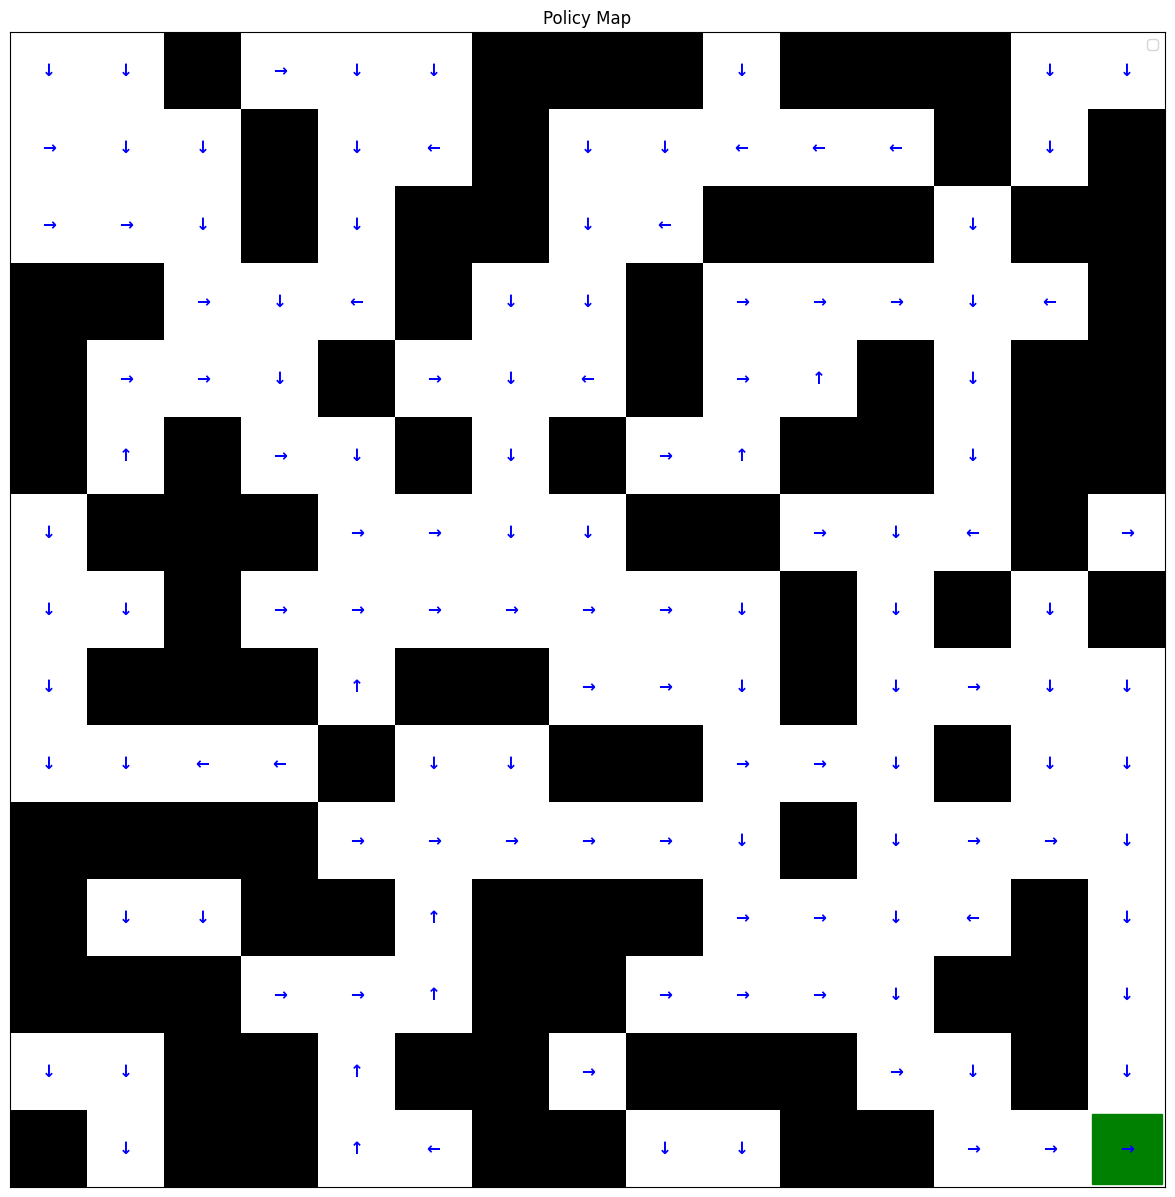

In [479]:
def plot_policy_map(model, qmaze):
    # Set up directions symbols
    directions = {
        LEFT: '←',
        UP: '↑',
        RIGHT: '→',
        DOWN: '↓'
    }
    
    # Set model to evaluation mode
    model.eval()

    # Get maze dimensions and calculate appropriate figure size
    nrows, ncols = qmaze.maze.shape
    figsize = (ncols, nrows)  # Adjust the divisor to change the overall size
    print(figsize)
    
    with torch.no_grad():
        fig, ax = plt.subplots(figsize=figsize)

        # Show the maze
        binary_maze = np.copy(qmaze.maze)
        print(binary_maze)
        target_row, target_col = qmaze.target
        binary_maze[target_row, target_col] = 1.0  # Ensure target cell is marked as traversable
        binary_maze = (binary_maze == 1).astype(int)  # Invert so walls are 0 (black)
        
        
        # Show the maze with black walls and white free cells
        ax.imshow(binary_maze, cmap='binary_r', interpolation='nearest')
        
        # For each free cell
        for cell in qmaze.free_cells + [qmaze.target]:  # Include target cell
            row, col = cell
            # Get state for current cell
            qmaze.reset(cell)
            state = qmaze.observe()
            
            # Get Q-values and best action
            state_tensor = torch.tensor(state, dtype=torch.float32).unsqueeze(0).to(device)
            qvalues = model(state_tensor)
            action = torch.argmax(qvalues).item()
            
            # Plot direction arrow
            ax.text(col, row, directions[action], 
                   ha='center', va='center',
                   color='blue', fontsize=12, fontweight='bold')
        
        # Mark target/cheese cell
        target_row, target_col = qmaze.target
        ax.plot(target_col, target_row, 'gs', markersize=50)
        
        # Customize plot
        plt.grid(True, alpha=0.2)
        plt.title('Policy Map')
        plt.xticks([])
        plt.yticks([])
        plt.legend()
        plt.savefig('images/policy-map.png')
        plt.show()

plot_policy_map(model, qmaze)
      